# Starting simple: Linear Regression

## Short Look at the Data
For this tutorial, I will use rental data that I scraped from Immoscout24. For a more detailed description and information on how I scraped the data set, you can check its description on [kaggle](https://www.kaggle.com/corrieaar/apartment-rental-offers-in-germany) where I occasionally also update the data.
For this analysis, we will concentrate on rental offers in Berlin but of course feel free to try out different cities or areas!

In [40]:
import sys
sys.path.append('../src/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import iqr, iqr_rule

In [36]:
plt.style.use("corrie")

In [44]:
d = pd.read_csv("../data/immo_data.csv", dtype={"geo_plz": str})

Before using the data, we will do a bit of preprocessing: We remove outliers where either the living area or the total rent is too low or too high. To remove outliers, the [Inter quartile range (IQR)](https://en.wikipedia.org/wiki/Interquartile_range#Outliers) is used. The IQR rule marks everything as outlier that's too far from the middle range of the data. Most of the data we throw away this way were typos or similar with unreasonable input values.
For a more thorough analysis, it might be useful to check that we don't throw away real cases and instead incorporate the outliers in further analysis.

In [49]:
d["totalRent"] = np.where(d["totalRent"].isnull(), d["baseRent"], d["totalRent"])

# since log doesn't work with 0, we replace 0 with 0.5
# seems reasonable tto say hat a rent of 0€ is the same as 50ct
d["livingSpace_m"] =  np.where(d["livingSpace"] <= 0, 0.5, d["livingSpace"])
d["totalRent_m"] = np.where(d["totalRent"] <= 0, 0.5, d["totalRent"])
d["logRent"] = np.log(d["totalRent_m"])
d["logSpace"] = np.log(d["livingSpace_m"])

not_outlier = iqr_rule(d["logSpace"], factor=1.5) & iqr_rule(d["logRent"], factor=1.5)
d = d[not_outlier]
berlin = d[(d.regio1 == "Berlin") ]

In this analysis, we want to predict the rent (`totalRent`) by the living area (`livingSpace`).

Have a short look at the data and these two variables!

In [50]:
berlin.iloc[0]

regio1                                                                 Berlin
serviceCharge                                                             125
heatingType                                                     floor_heating
telekomTvOffer                                                  ONE_YEAR_FREE
telekomHybridUploadSpeed                                                  NaN
newlyConst                                                               True
balcony                                                                  True
electricityBasePrice                                                      NaN
picturecount                                                                6
pricetrend                                                               7.49
telekomUploadSpeed                                                         40
totalRent                                                                1046
yearConstructed                                                 

In [51]:
berlin.shape

(7092, 52)

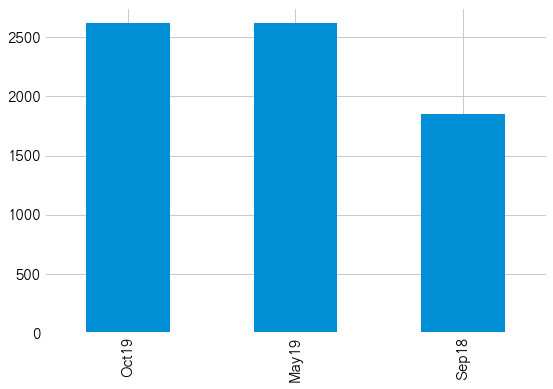

In [62]:
berlin.date.value_counts().plot.bar()
plt.title("Number of cases per scrape time")
plt.show()

In [58]:
berlin.corr()

,serviceCharge,telekomHybridUploadSpeed,newlyConst,balcony,electricityBasePrice,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,...,numberOfFloors,noRoomsRange,garden,livingSpaceRange,heatingCosts,lastRefurbish,livingSpace_m,totalRent_m,logRent,logSpace
serviceCharge,1.000000,NaN,0.068294,0.169764,-8.023866e-03,0.180880,-0.032964,-0.048949,0.637221,0.183751,...,2.448584e-02,0.499480,0.099476,0.617345,4.809631e-01,-2.064810e-02,0.625886,0.637221,0.612898,0.615842
telekomHybridUploadSpeed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
newlyConst,0.068294,NaN,1.000000,0.167290,-5.530394e-02,0.080291,0.039857,0.076350,0.209439,0.528885,...,8.244309e-02,0.082435,0.094604,0.063749,8.317371e-03,1.422385e-01,0.055550,0.209439,0.215594,0.068379
balcony,0.169764,NaN,0.167290,1.000000,-1.395029e-02,0.092909,-0.074795,0.004735,0.176456,0.290107,...,3.922812e-02,0.188202,0.098815,0.195327,1.086853e-01,4.044212e-02,0.193653,0.176456,0.184641,0.213870
electricityBasePrice,-0.008024,NaN,-0.055304,-0.013950,1.000000e+00,0.019915,0.017950,-0.021584,0.003923,-0.030259,...,-4.695372e-16,-0.011940,0.009251,0.005777,-8.337427e-16,1.071955e-14,0.000585,0.003923,-0.001024,-0.003713
picturecount,0.180880,NaN,0.080291,0.092909,1.991516e-02,1.000000,0.060001,0.001806,0.377344,-0.038880,...,-1.231319e-02,0.231857,0.136733,0.309554,2.494427e-01,7.752035e-02,0.315655,0.377344,0.391798,0.303932
pricetrend,-0.032964,NaN,0.039857,-0.074795,1.794951e-02,0.060001,1.000000,-0.081751,0.086727,-0.145257,...,1.453482e-01,-0.048295,-0.078556,-0.030397,6.745129e-03,3.289204e-02,-0.031976,0.086727,0.102276,-0.031820
telekomUploadSpeed,-0.048949,NaN,0.076350,0.004735,-2.158413e-02,0.001806,-0.081751,1.000000,-0.066758,0.055584,...,-1.704165e-02,-0.002485,-0.032169,-0.049645,-5.674581e-02,8.041680e-02,-0.048352,-0.066758,-0.065293,-0.043089
totalRent,0.637221,NaN,0.209439,0.176456,3.923128e-03,0.377344,0.086727,-0.066758,1.000000,0.079445,...,3.443936e-02,0.624750,0.120596,0.782584,5.088027e-01,5.440610e-02,0.798040,1.000000,0.969151,0.769150
yearConstructed,0.183751,NaN,0.528885,0.290107,-3.025939e-02,-0.038880,-0.145257,0.055584,0.079445,1.000000,...,1.972486e-01,0.067339,0.098415,0.008290,5.812644e-05,1.137695e-01,0.000356,0.079445,0.069064,0.021456


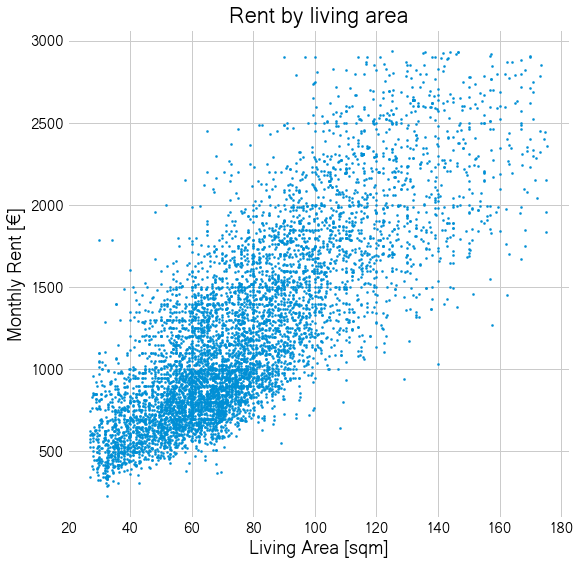

In [57]:
plt.figure(figsize=(9,9))
plt.scatter(berlin.livingSpace, berlin.totalRent, s=4)
plt.title("Rent by living area")
plt.xlabel("Living Area [sqm]")
plt.ylabel("Monthly Rent [€]")
plt.show()